In [1]:
import numpy as np
import matplotlib.pyplot as plt
import types
from tqdm import tqdm
noglobal = lambda f: types.FunctionType(f.__code__, globals().copy(), argdefs=f.__defaults__)

In [2]:
@noglobal
def lennJones_acc(i, x, y, rCut, N, L):
    xi, yi = x[i], y[i] 
    ax = 0.0
    ay = 0.0
    for j in range(N):
        if j != i:
            xij = (xi-x[j])
            yij = (yi-y[j])
            
            #-- apply periodic boundary condition
            if(abs(xij) > L/2):
                if(xij < 0): xij = xij + L
                else: xij = xij - L
            
            if(abs(yij) > L/2):
                if(yij < 0): yij = yij + L
                else: yij = yij - L
            
            rij = np.sqrt( xij**2. + yij**2. )
            
            if (rij <= rCut):
                fij = 24.*(2/(rij)**13. - 1./(rij)**7.)
                ax += fij * xij/rij # fij * cos(theta_ij)
                ay += fij * yij/rij # fij * sin(theta_ij)
    
    return np.array([ax, ay])      

In [3]:
N = 20
L = 10

dt = 0.02
Nt = 75

dR = 0.5
v0 = 1.0

rCut = 3.0

randSeed = 12345

px = np.empty((N, Nt))
py = np.empty((N, Nt))
vx = np.empty((N, Nt))
vy = np.empty((N, Nt))

xprev = np.empty((N, 1))
yprev = np.empty((N, 1))

### set initial position and velocities

In [4]:
#-- initialize RNG with a seed (to get reproducible results)

xi = np.arange(0, L, 2.)
yi = np.arange(0, L, 2.5)
xx, yy = np.meshgrid(xi, yi)

#-- put it on a regular grid first
px[:,0] = np.reshape(xx, (1, N)).flatten() + 1.25
py[:,0] = np.reshape(yy, (1, N)).flatten() + 1.25

#-- and randomly displace a bit
rng = np.random.default_rng(seed=randSeed)
dx = 2*(rng.random(N) - 0.5)*dR
dy = 2*(rng.random(N) - 0.5)*dR
px[:,0] += dx  
py[:,0] += dy

#-- initialize velocity
th = 2 * np.pi * rng.random(N)
vx[:,0] = v0 * np.cos(th)
vy[:,0] = v0 * np.sin(th)

#-- fictitious previous position
#-- this is needed to start the Verlet algorithm
xprev = px[:,0] - vx[:,0]*dt
yprev = py[:,0] - vy[:,0]*dt

### Plot the configuration at t=0

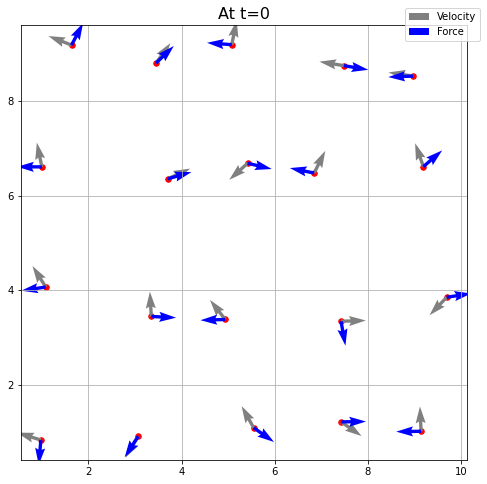

In [5]:
plt.figure(figsize=(8,8))

plt.scatter(px[:,0], py[:,0], s=30, color='r')
plt.quiver(px[:,0], py[:,0], vx[:,0], vy[:,0], color='grey', label='Velocity')

ax, ay = lennJones_acc(0, px[:,0], py[:,0], rCut, N, L)
plt.quiver(px[0,0], py[0,0], ax, ay, color='blue', label='Force')

for i in range(1,N):
    ax, ay = lennJones_acc(i, px[:,0], py[:,0], rCut, N, L)
    plt.quiver(px[i,0], py[i,0], ax, ay, color='blue')
    
plt.legend(loc="upper left", bbox_to_anchor=(0.85, 1.05))
plt.title("At t=0", fontsize=16)
plt.grid()
plt.show()

### Integrate the equations of motion

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1301.99it/s]


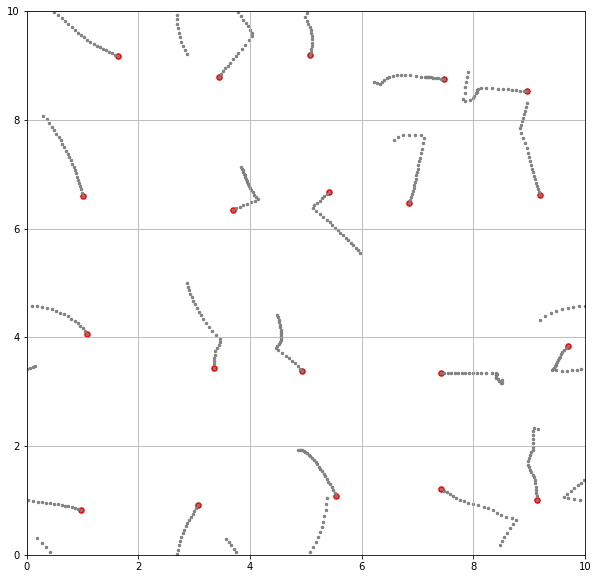

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(px[:,0], py[:,0], s=30, color='r')

#-- step through in time
for ti in tqdm(range(Nt-1)):
    #-- plot position
    if (ti%3 == 0):
        plt.scatter(px[:,ti], py[:,ti], s=6, color='grey')
    
    #-- step through the particles at this time
    for j in range(N):
    
        ax, ay = lennJones_acc(j, px[:,ti], py[:,ti], rCut, N, L)
    
        #-- position update of the j-th particle
        px[j, ti+1] = 2.*px[j, ti] - xprev[j] + ax*dt*dt
        py[j, ti+1] = 2.*py[j, ti] - yprev[j] + ay*dt*dt
        
        #-- apply periodic bndry condition
        px[j, ti+1] = px[j, ti+1] % L
        py[j, ti+1] = py[j, ti+1] % L
      
    xprev = px[:, ti]
    yprev = py[:, ti]
    
    # velocity update of all particles
    vx[:,ti] = 0.5*(px[:,ti+1] - px[:,ti])/dt
    vy[:,ti] = 0.5*(py[:,ti+1] - py[:,ti])/dt    
    
plt.grid()
plt.xlim(0, L)
plt.ylim(0, L)
plt.show()